# National Climate Dynamics Workshop - Python Short Course

The remainder of this short course will introduce `pygeode`, a Python package designed for accessing, processing, and visualizing gridded geophysical data. It is an alternative to `xarray` or to `IRIS`. PyGeode uses `numpy` and `matplotlib` extensively for underlying computations and plotting, and is designed around three main principles: 

1. Data should be represented and manipulated in geophysical coordinates, not in array indices
2. Data should be 'lazy-loaded', i.e. left on disk until needed for computation, and then accessed in a memory-friendly way
3. Plotting defaults should be as close to publication quality as possible

Full documentation about pygeode including a tutorial, gallery, and API reference, can be found at [pygeode.github.io](https://pygeode.github.io).

This introduction is split into three Jupyter notebooks. Each 'workbook' consists of a set of pre-written examples to introduce some of pygeode functionality, followed by a simple example to give you the chance to work with pygeode yourself.

## PyGeode Workbook #1: The basic nuts and bolts

This first workbook introduces pygeode dataset (`Dataset`), variable (`Var`), and axis (`Axis`) objects, and demonstrates simple plotting.

In [1]:
# C0.2 Setup matplotlib backend for inline interactive plots
%matplotlib ipympl

In [2]:
# C0.1 Import pygeode, numpy, and matplotlib plotting packages
import pygeode as pyg
import numpy as np
from matplotlib import pyplot as plt

### 1. A First Plot

To get us started, we'll look first at making a plot with an example dataset, built in to the 'tutorial' module within pygeode.

In [3]:
# C1.1 Import an example dataset and examine it
from pygeode.tutorial import t1

print(t1)

<Dataset>:
Vars:
  Temp (lat,lon)  (31,60)
Axes:
  lat <Lat>      :  90 S to 90 N (31 values)
  lon <Lon>      :  0 E to 354 E (60 values)
Global Attributes:
  history        : Synthetic Temperature data generated by pygeode


This object introduces the three main objects that pygeode provides. `t1` is a dataset; a collection object that can contain variables and axes. In this case it contains a single variable `Temp`, representing temperature data on a coarse lat-lon grid (31 by 60, or 3$^\circ$ by 6$^\circ$). The dimensions of this grid are described by the two axes, named `lat` and `lon`. These are recognized explicitly by pygeode as representing latitudes and longitudes. 

We can now look at this variable:

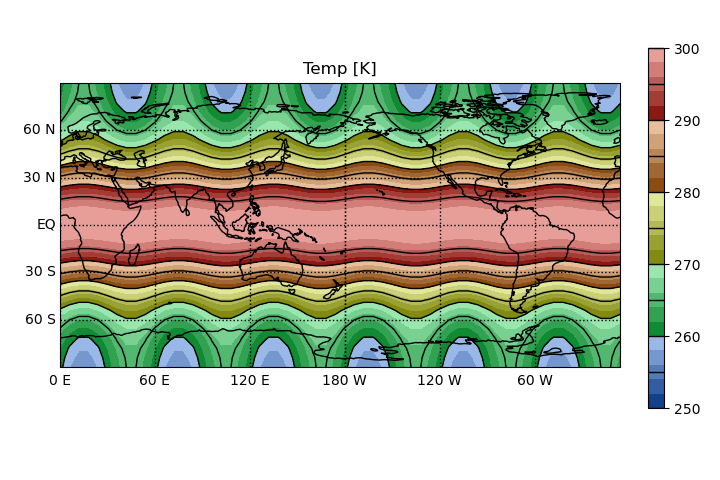

In [4]:
# C1.4 Plot synthetic temperature field
pyg.showvar(t1.Temp)

Pygeode recognizes that this variable has two dimensions that correspond to a geographical grid. The plot is produced using `matplotlib`, and recognizing that the data is geographical, pygeode uses `cartopy` to overlay a map and labels axes accordingly.

The choice of contour levels and color map are also chosen automatically in a way that is different from `matplotlib` defaults. Contour levels are chosen to be round numbers; for instance in this case, each shaded contour is 2 K with colorbar tick labels every 10 K that correspond to changes in hue in the colormap. This produces high contrast at specific contour levels, making it much easier to quantify the underlying data from this visualization. 

The colormap is also automatically chosen to be sequential (as in this case) or divergent, depending on the data. For instance, if we convert to degrees Celsius:

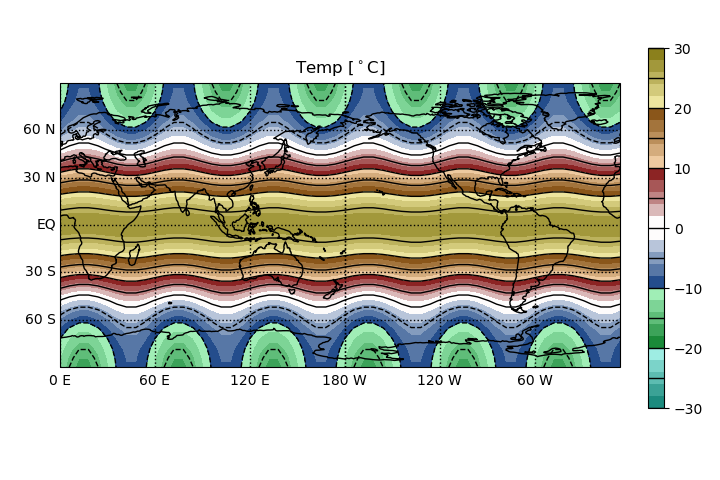

In [5]:
# C1.5 Demonstrate divergent color maps

# Pygeode variables support basic arithmetical operations 
T = t1.Temp - 273.15
T.units = r'$^\circ$C'

pyg.showvar(T)

We'll look further at how to customize these choices later in these workbooks.

### 2. Creating PyGeode variables and axes

We'll see several different methods for creating your own PyGeode variables. As a first example, we'll look at reading data in from a ASCII file in csv format (comma-separated values). We'll use `numpy.loadtxt()` to read timeseries data into numpy arrays, then use them to create PyGeode variables.

In [6]:
#C2.1 Read in time series of temperature data from sample csv file

# Set this path to wherever you've stored the sample data provided.
data_pth = './'

# The following two lines each read a single column of data.
timestamp   = np.genfromtxt(data_pth + "weather-raw.csv", delimiter=",", skip_header=1, usecols=(0), dtype='str')
temperature = np.genfromtxt(data_pth + "weather-raw.csv", delimiter=",", skip_header=1, usecols=(1))

# Temperatures are stored in degrees Celsius * 10; the following converts to degrees C
temperature = temperature.astype('d') / 10.

# Examine the first timestamp
print(timestamp[0])

1995-06-30 15:30:00


We now have the temperature time series data in the form of numpy arrays. In order to create a PyGeode variable, we need to first create an axis object that represents the calendar time. There various ways to do this, but one convenient way in this context is to first extract the calendar year, month, day, etc. into independent numpy arrays ...

In [7]:
#C2.2 Split up timestamp into components 
yrs = np.array([int(t[  : 4]) for t in timestamp])
mns = np.array([int(t[ 5: 7]) for t in timestamp])
dys = np.array([int(t[ 8:10]) for t in timestamp])
hrs = np.array([int(t[11:13]) for t in timestamp])
mts = np.array([int(t[14:16]) for t in timestamp])
scs = np.array([int(t[17:19]) for t in timestamp])

... and then use this to create a PyGeode time axis.

In [8]:
#C2.3 Create PyGeode time axis
time2 = pyg.StandardTime(year=yrs, month=mns, day=dys, hour=hrs, minute=mts, second=scs, units='days')

#### Calendars

PyGeode recognizes several calendars, including the standard Gregorian calendar in addition to 365-day and 360-day calendars. 

Here we've created a standard calendar; the data covers a time period from June 1995 to June 2020, including over 400,000 individual observations.

Internally, PyGeode represents the time axis as an offset from a fixed start date; the offset can be defined in different units, and the start date is arbitrary. The second print statement uses standart python slicing notation to access the first five elements of the axis, which represent days since 15:00 Jun 30 1995.

In [9]:
#C2.4 Print readable representation of time axis
print(time2)

time <StandardTime>:  Jun 30, 1995 15:30:00 to Dec 13, 2022 02:00:00 (474929 values)


In [10]:
#C2.5 Print first five elements
print(time2[:5])

[0.         0.02083333 0.04166667 0.0625     0.08333333]


#### Creating a variable
We can now create a variable representing the temperature time series. To do this we need to provide a list of axes that defines the grid, an array of values with the appropriate shape, and a name:

In [11]:
#C2.6 Create PyGeode variable
temp = pyg.Var((time2,), values = temperature, name = 'Temperature')

print(temp)

<Var 'Temperature'>:
  Shape:  (time)  (474929)
  Axes:
    time <StandardTime>:  Jun 30, 1995 15:30:00 to Dec 13, 2022 02:00:00 (474929 values)
  Attributes:
    {}
  Type:  Var (dtype="float64")


Now that we have our time series as a PyGeode variable, we can use a range of different tools for subsetting and plotting the temperature data. In this case, as a one-dimensional dataset, `showvar()` will create a line plot instead of a contour plot. Labeling of the time axis is handled automatically, based on the range of time visible in the plot.

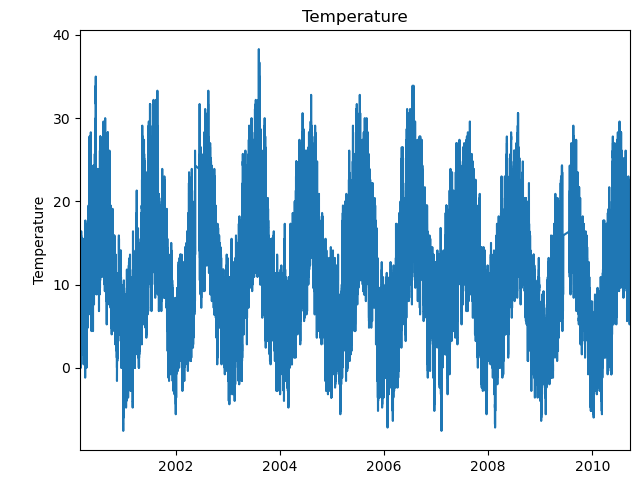

In [12]:
#C2.7 Plot subset of time series
pyg.showvar(temp(time = ('1 Mar 2000', '21 Sep 2010')))

### 3. Manipulating Variables and Axes

Because PyGeode is aware of the geophysical meaning of different dimensions, it can make sensible decisions about how to broadcast variables defined on different grids. As an example, we'll use PyGeode to create one of the analytical horizontal wind fields used to test tracer transport schemes in dynamical cores described by Nair and Lauritzen (2010) [doi:10.1016/j.jcp.2010.08.014](http://dx.doi.org/10.1016/j.jcp.2010.08.014).

We'll first define a horizontal stream function

$$\psi = k \sin(\lambda - ct)^2 \cos(\phi)^2 \cos(\pi t / T)$$

where $k$, $c$, and $T$ are constants, $\lambda$ is longitude, $\phi$ is latitude, and $t$ is time. The resulting streamfunction is defined on a three dimensional grid (lat, lon, time). 

Generating this field in PyGeode is straightforward. We'll start by using some helper functions that PyGeode provides to create relevant `Axis` objects.

In [13]:
#C3.1 Create axes which will define the grid

# Create regularly-spaced longitude and latitude axes that span the globe.
lon = pyg.regularlon(360)
lat = pyg.regularlat(180)

# Create a timeaxis 200 days long, starting 1 Jan 2020.
time = pyg.modeltime365n('1 Jan 2020', 200)

Creating the streamfunction involves a simple translation of the formula:

In [14]:
#C3.2 Compute streamfunction

# Define constants
a = 6371e3   # Radius of the Earth in m
T = 50       # Timescale in days
c = 360. / T # Translational velocity in degrees longitude per day
k = 10 * a   # Overall flow rate in metres squared per second

# Basic arithmetical operations apply as expected; Pygeode provides wrappers to many numpy functions
psi = k * pyg.sind((lon - c*time)/2)**2 * pyg.cosd(lat)**2 * pyg.cos(np.pi * time / T)

print(psi)

<Var '((((sind((lon-time)/2)**2)*63710000.0)*(cosd(lat)**2))*cos(time))'>:
  Shape:  (lon,time,lat)  (360,200,180)
  Axes:
    lon <Lon>      :  0 E to 359 E (360 values)
    time <ModelTime365>:  Jan 1, 2020 00:00:00 to Jul 19, 2020 00:00:00 (200 values)
    lat <Lat>      :  90 S to 90 N (180 values)
  Attributes:
    {}
  Type:  Mul_Var (dtype="float64")


Because PyGeode knows that `time`, `lat`, and `lon` represent different geophysical axes, it will automatically broadcast the values appropriately, computing external products where necessary. The result is a three-dimensional numerical grid.

The resulting variable has an awkward name, and might not have the axes in the appropriate order:

In [15]:
#C3.3 Transpose and rename variable
psi = psi.transpose('time', 'lat', 'lon')
psi = psi.rename('psi')
print(psi)

<Var 'psi'>:
  Shape:  (time,lat,lon)  (200,180,360)
  Axes:
    time <ModelTime365>:  Jan 1, 2020 00:00:00 to Jul 19, 2020 00:00:00 (200 values)
    lat <Lat>      :  90 S to 90 N (180 values)
    lon <Lon>      :  0 E to 359 E (360 values)
  Attributes:
    {}
  Type:  RenamedVar (dtype="float64")


Pygeode also provides more advanced numerical operations; for instance one can take numerical derivatives (using a centered difference approximation by default). Here we can use this to compute the horizontal wind field from the stream function.

$$ u = -\dfrac{1}{a} \partial_\phi \psi $$
$$ v = \dfrac{1}{a \cos \phi} \partial_\lambda \psi $$

In [16]:
#C3.5 Compute horizontal winds using a numerical derivative

# Pygeode uses the axis coordinate values to define the derivative
# Because latitude is defined in degrees, not in radians, we need to account for an additional factor of pi/180.
u = -psi.deriv('lat') * 180. / (np.pi * a)

# Another approach is to provide an alternative coordinate value to use
# In this case we can define an 'x' coordinate that takes into account the shortening of parallels as you approach the poles
x = a * psi.lon * np.pi / 180. * pyg.cosd(psi.lat) + 0*psi.time
v = psi.deriv('lon', dx = x)

# Finally we can rename these variables
u = u.rename('u')
v = v.rename('v')
print(u)
print(v)

<Var 'u'>:
  Shape:  (time,lat,lon)  (200,180,360)
  Axes:
    time <ModelTime365>:  Jan 1, 2020 00:00:00 to Jul 19, 2020 00:00:00 (200 values)
    lat <Lat>      :  90 S to 90 N (180 values)
    lon <Lon>      :  0 E to 359 E (360 values)
  Attributes:
    {}
  Type:  RenamedVar (dtype="float64")
<Var 'v'>:
  Shape:  (time,lat,lon)  (200,180,360)
  Axes:
    time <ModelTime365>:  Jan 1, 2020 00:00:00 to Jul 19, 2020 00:00:00 (200 values)
    lat <Lat>      :  90 S to 90 N (180 values)
    lon <Lon>      :  0 E to 359 E (360 values)
  Attributes:
    {}
  Type:  RenamedVar (dtype="float64")


### 4. Basics of customizing plots

To finish this first workbook, we'll look at some of the basics of customizing plots.

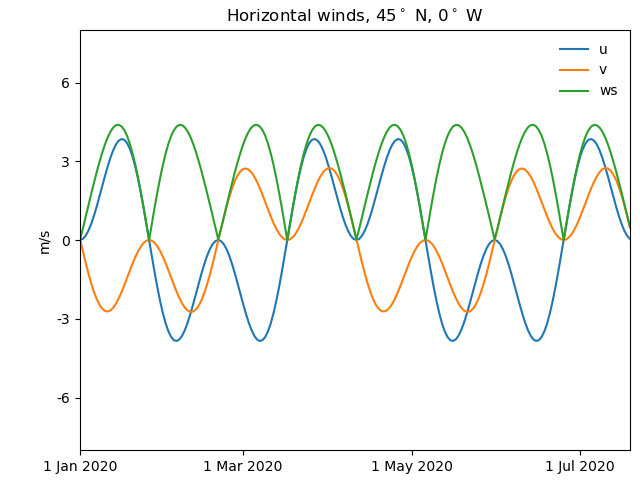

In [17]:
#4.1 Overplot several time series, modify labels

#Make a figure
fig = plt.figure()

# Turn off 'interactive mode' to build plot
plt.ioff()

# Define helper function
def sel(v): return v(lat = 45, lon = 0)

# Compute wind speed
ws = pyg.sqrt(u**2 + v**2).rename('ws')

# Show u, v, and wind speed at fixed point
ax = pyg.showlines([sel(u), sel(v), sel(ws)])

# Change title, y axis properties
ax.setp(title = r'Horizontal winds, 45$^\circ$ N, 0$^\circ$ W', ylim = (-8, 8), ylabel='m/s')
ax.setp_yaxis(major_locator = plt.MultipleLocator(3))

#Put the plot in the figure
ax.render(fig=fig)

# Turn on interactive mode
plt.ion()

#Show the plot
plt.show()

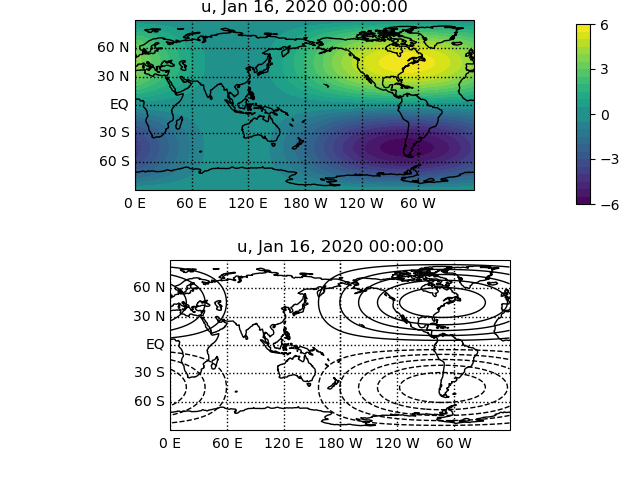

In [18]:
#4.2 Set contour intervals and use a different color bar

fig = plt.figure() #Make a figure

plt.ioff()  # Again, turn off interactive mode

# Helper function to return the 15th timestep
def sel(var): return var(i_time = 15) 

# PyGeode provides helper functions to produce arguments that configure contour plots

# Filled contours
cf = pyg.clfdict(cdelt = 3, ndiv = 2, nf = 6, nl = 0, style = 'div', cmap = plt.cm.viridis)

# Contour lines
cl = pyg.cldict(cdelt = 1, nozero = True)

# Create two plots
ax1 = pyg.showvar(sel(u), **cf)
ax2 = pyg.showvar(sel(u), **cl)

# This creates a grid out of individual plots
ax = pyg.plot.grid([[ax1], [ax2]])

#Put the plot in the figure
ax.render(fig=fig)

plt.ion()

#Show the plot
plt.show()

## Exercises

Produce and customize your own plot. Two possible options:
1. Read in other fields from the csv file we explored in section 2 and explore the time series
2. Customize contour intervals and colorbar used above